## Import libs and set pd-options

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
import pandas as pd
import numpy as np
import pandas_profiling

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

Populating the interactive namespace from numpy and matplotlib


## Import CSV-file

In [2]:
df = pd.read_csv('..\data\listings.csv')
df.id.count()

24422

## Show all colums to retrieve first information about the data

In [3]:
for i in df.columns:
    print(i)

id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_ni

## Create new DataFrame with relevant columns

In [4]:
target_df = df[['accommodates', 'number_of_reviews', 'review_scores_rating', 'neighbourhood_group_cleansed', 'beds', 'bedrooms', 'room_type', 'cancellation_policy', 'name', 'price']]

## Clean 'price' column

In [5]:
def remove_currency(prices_with_currency):
    price = float(prices_with_currency.replace(',', '').replace('$', ''))
    return price

target_df['price'] = target_df['price'].map(remove_currency)

c:\users\luisraphaelramer\analyticsproit\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [6]:
#target_df.profile_report(style={'full_width': True})

## Check for duplicate rows, caused by a warning from 'target_df.profile_report'

In [7]:
duplicateRowsDF = target_df[target_df.duplicated()]
#duplicateRowsDF.count()
#duplicateRowsDF

### &rarr; It seems the duplicate rows are column-scoped, so the warning can be ignored for now

## Check for rows containing 'zero' (0.0) in bedrooms, caused by a warning from 'target_df.profile_report'

### There are 1813 rows with 'zero' (0.0) bedrooms however most of them have beds
### &rarr; Check for rows with 'zero' in columns 'bedrooms' AND 'bed' and drop these rows

In [8]:
#no_bed_df = target_df[(target_df['bedrooms']==0) & (target_df['beds']==0)]
#no_bed_df.count()

In [9]:
target_df = target_df.drop(target_df[(target_df['bedrooms'] == 0) & (target_df['beds'] == 0)].index)
target_df = target_df.drop((target_df[(pd.isnull(target_df['bedrooms'])) | (pd.isnull(target_df['beds']))].index))
target_df.count()

accommodates                    24332
number_of_reviews               24332
review_scores_rating            19757
neighbourhood_group_cleansed    24332
beds                            24332
bedrooms                        24332
room_type                       24332
cancellation_policy             24331
name                            24282
price                           24332
dtype: int64

## Warning from 'target_df.profile_report' says that 'number_of_reviews' and 'review_scores_rating' have 4136 rows containing 'zero' (0.0) resp. 4610 rows containing missing values (NaN)
#### Hypothesis
> "An array containing rows with wehere at least one of those column values are zero (0.0) or missing (NaN) should have the length of 4610"

In [10]:
#no_review_df = target_df[(target_df['number_of_reviews']==0) | (pd.isnull(target_df['review_scores_rating']))]
#no_review_df.count()
#no_review_df2 = no_review_df[(no_review_df['number_of_reviews']!=0) & (pd.isnull(no_review_df['review_scores_rating']))]
#no_review_df2.count

## To not have to delete/ignore the 4610 rows containing neither a review_scores_rating nor number_of_reviews, I will fill in the mean of the other columns for review_scores_rating and add another column which tells if the review_scores_rating is calculated or real.

In [11]:
target_df['is_review_scores_rating_real'] = ''
target_df.columns

Index(['accommodates', 'number_of_reviews', 'review_scores_rating',
       'neighbourhood_group_cleansed', 'beds', 'bedrooms', 'room_type',
       'cancellation_policy', 'name', 'price', 'is_review_scores_rating_real'],
      dtype='object')

In [12]:
for index, row in target_df.iterrows():
    if pd.isna(row['review_scores_rating']):
        #print(target_df.at[index, row['is_review_scores_rating_real']])
        target_df.at[index, 'is_review_scores_rating_real'] = 0
        
        
    else:
       #print(target_df.at[index, row['is_review_scores_rating_real']])
        target_df.at[index, 'is_review_scores_rating_real'] = 1

target_df

,accommodates,number_of_reviews,review_scores_rating,neighbourhood_group_cleansed,beds,bedrooms,room_type,cancellation_policy,name,price,is_review_scores_rating_real
0,1,18,82.0,Mitte,1.0,1.0,Private room,moderate,cafeheaven Pberg/Mitte/Wed for the summer 2019,21.0,1
1,3,127,93.0,Mitte,2.0,1.0,Entire home/apt,moderate,Berlin-Mitte Value! Quiet courtyard/very central,60.0,1
2,4,145,93.0,Pankow,2.0,1.0,Entire home/apt,strict_14_with_grace_period,Fabulous Flat in great Location,90.0,1
3,1,27,89.0,Tempelhof - Schöneberg,1.0,1.0,Private room,strict_14_with_grace_period,BerlinSpot Schöneberg near KaDeWe,28.0,1
4,2,126,99.0,Friedrichshain-Kreuzberg,1.0,1.0,Entire home/apt,moderate,Stylish East Side Loft in Center with AC & 2 b...,125.0,1
...,...,...,...,...,...,...,...,...,...,...,...
24416,2,0,NaN,Reinickendorf,1.0,1.0,Entire home/apt,flexible,"Gemütliche, helle Unterkunft",40.0,0
24417,2,0,NaN,Friedrichshain-Kreuzberg,1.0,1.0,Private room,flexible,Spacious Room in trendy Area,54.0,0
24419,1,0,NaN,Pankow,1.0,0.0,Private room,flexible,Gemütliches Privatzimmer in Friedrichshain(zen...,36.0,0
24420,2,0,NaN,Friedrichshain-Kreuzberg,2.0,1.0,Private room,flexible,Schönes Balkonzimmer im Herzen von Friedrichshain,50.0,0


## Now that we have a column telling if the 'review_scores_rating' value is real or not, we can replace the NaN values with the column's mean

In [13]:
target_df['review_scores_rating'] = target_df['review_scores_rating'].fillna(round(target_df['review_scores_rating'].mean(), 2))
target_df

,accommodates,number_of_reviews,review_scores_rating,neighbourhood_group_cleansed,beds,bedrooms,room_type,cancellation_policy,name,price,is_review_scores_rating_real
0,1,18,82.00,Mitte,1.0,1.0,Private room,moderate,cafeheaven Pberg/Mitte/Wed for the summer 2019,21.0,1
1,3,127,93.00,Mitte,2.0,1.0,Entire home/apt,moderate,Berlin-Mitte Value! Quiet courtyard/very central,60.0,1
2,4,145,93.00,Pankow,2.0,1.0,Entire home/apt,strict_14_with_grace_period,Fabulous Flat in great Location,90.0,1
3,1,27,89.00,Tempelhof - Schöneberg,1.0,1.0,Private room,strict_14_with_grace_period,BerlinSpot Schöneberg near KaDeWe,28.0,1
4,2,126,99.00,Friedrichshain-Kreuzberg,1.0,1.0,Entire home/apt,moderate,Stylish East Side Loft in Center with AC & 2 b...,125.0,1
...,...,...,...,...,...,...,...,...,...,...,...
24416,2,0,94.61,Reinickendorf,1.0,1.0,Entire home/apt,flexible,"Gemütliche, helle Unterkunft",40.0,0
24417,2,0,94.61,Friedrichshain-Kreuzberg,1.0,1.0,Private room,flexible,Spacious Room in trendy Area,54.0,0
24419,1,0,94.61,Pankow,1.0,0.0,Private room,flexible,Gemütliches Privatzimmer in Friedrichshain(zen...,36.0,0
24420,2,0,94.61,Friedrichshain-Kreuzberg,2.0,1.0,Private room,flexible,Schönes Balkonzimmer im Herzen von Friedrichshain,50.0,0


## Check target_df..profile_report() again for further data cleaning

In [14]:
#target_df.profile_report(style={'full_width': True})

In [15]:
target_df[(target_df['price']>600)].sort_values(by='price', ascending=False)
target_df = target_df.drop(target_df[target_df['price']>600].index)

## After exploring the prices above 600 dollars, i decide to drop these rows as they seem to contain bad data and its only 93 of them

In [16]:
#target_df.profile_report(style={'full_width': True})

## Add and preprocess (copied from Victor's Notebook)

In [17]:
target_df['amenities'] = df['amenities']

In [18]:
am = target_df.loc[11,"amenities"]
am.replace("{","").replace("}","").split(",")

['TV',
 'Wifi',
 'Kitchen',
 'Elevator',
 '"Indoor fireplace"',
 'Heating',
 '"Family/kid friendly"',
 'Washer',
 '"Smoke detector"',
 'Essentials',
 'Hangers',
 'Iron',
 '"High chair"',
 '"Children’s books and toys"',
 '"Pack ’n Play/travel crib"',
 '"Hot water"',
 'Refrigerator',
 '"Dishes and silverware"',
 '"Long term stays allowed"']

In [19]:
#methods for amenity cleaning:
def clean_amenities(a):
    return a.replace("{","").replace("}","").split(",")

def flatten_nested_list(nested_list):
    return [item for sub_list in nested_list for item in sub_list]


target_df["amenities_list"] = target_df["amenities"].map(clean_amenities)


amenities_flat = flatten_nested_list(target_df["amenities_list"].values)

In [20]:
amenities_flat

['"Cable TV"',
 'Internet',
 'Wifi',
 '"Free street parking"',
 'Heating',
 '"Family/kid friendly"',
 'Washer',
 '"Smoke detector"',
 'Essentials',
 '"Lock on bedroom door"',
 '"Hair dryer"',
 '"Hot water"',
 '"Host greets you"',
 'TV',
 '"Cable TV"',
 'Wifi',
 'Kitchen',
 'Gym',
 'Heating',
 '"Family/kid friendly"',
 '"Smoke detector"',
 'Essentials',
 'Shampoo',
 '"Lock on bedroom door"',
 'Hangers',
 '"Hair dryer"',
 'Iron',
 '"Laptop friendly workspace"',
 '"Self check-in"',
 'Lockbox',
 '"Private living room"',
 'Bathtub',
 '"Hot water"',
 '"Bed linens"',
 '"Extra pillows and blankets"',
 'Microwave',
 '"Coffee maker"',
 'Refrigerator',
 'Dishwasher',
 '"Dishes and silverware"',
 '"Cooking basics"',
 'Stove',
 '"Luggage dropoff allowed"',
 '"Long term stays allowed"',
 'Internet',
 'Wifi',
 'Kitchen',
 '"Buzzer/wireless intercom"',
 'Heating',
 '"Family/kid friendly"',
 'Washer',
 '"Smoke detector"',
 '"Carbon monoxide detector"',
 '"First aid kit"',
 '"Safety card"',
 '"Fire exti

In [21]:
from collections import Counter

In [22]:
amenities_count = Counter(amenities_flat)
amenities_count
len(amenities_count)
sorted(amenities_count.items(), key= lambda x: x[1], reverse=True)
main_amenities = ['Wifi', 'Heating', 'Kitchen']
def is_in_amenities(key, a):
    if key in a:
        return 1
    else:
        return 0
for a in main_amenities:
    target_df["has_" + a] = target_df["amenities_list"].map(lambda x: is_in_amenities(a, x))

In [23]:
# put it all together

def clean_amenities(a):
        return a.replace("{","").replace("}","").split(",")
    
def is_in_amenities(a, amenities):
    """Return 1 if a single amenity, e.g. 'Wifi', is present in a list of amenities. 
    Apply this function using map to a pandas column"""
    if a in amenities:
        return 1
    else:
        return 0
    
def extract_amenities(df, amenities="all"):
    """Add to your dataframe df columns indicating whether a certain amenity is represented in the apartment (row).
    Specify the amenities of interest using pthe parameter amenities, e.g. amenities = ['Wifi', 'Heating', 'Kitchen'].
    >>>extract_amenities(df, amenities = ['Wifi', 'Heating', 'Kitchen'])
    """
    target_df["amenities_list"] = target_df["amenities"].map(clean_amenities)
    
    if amenities == "all":
        all_amenities_flat = flatten_nested_list(df["amenities_list"].values)
        amenities = list(set(all_amenities_flat))
        
    for a in amenities:
        df["has_" + a] = df["amenities_list"].map(lambda x: is_in_amenities(a, x))
        
    return df.drop(["amenities_list", "amenities"])

def count_amenities(df):
    """Compute for each amenity the number of occurences in the entire dataset"""
    df["amenities_list"] = df["amenities"].map(clean_amenities)
    all_amenities_flat = flatten_nested_list(df["amenities_list"].values)
    all_amenities_count = Counter(all_amenities_flat)
    
    return sorted(amenities_count.items(), key= lambda x: x[1], reverse=True)

In [24]:
target_df.drop(["amenities", "amenities_list"], axis=1, inplace=True)
target_df.sample(10)

,accommodates,number_of_reviews,review_scores_rating,neighbourhood_group_cleansed,beds,bedrooms,room_type,cancellation_policy,name,price,is_review_scores_rating_real,has_Wifi,has_Heating,has_Kitchen
12484,2,3,93.00,Lichtenberg,1.0,0.0,Entire home/apt,moderate,Skyline Apartement - perfect for a short stay,40.0,1,0,1,1
22091,6,4,95.00,Neukölln,2.0,2.0,Entire home/apt,flexible,4 Zimmer Salon nähe Tempelhofer Feld in Neukölln,100.0,1,1,1,1
22999,1,0,94.61,Tempelhof - Schöneberg,1.0,1.0,Private room,flexible,Cozy room with sofa in Berlin,20.0,0,1,1,1
1649,2,273,98.00,Tempelhof - Schöneberg,0.0,1.0,Entire home/apt,strict_14_with_grace_period,Luxury Apt & SAUNA on KuDamm/KaDeWe,49.0,1,1,1,1
21853,2,2,100.00,Neukölln,1.0,1.0,Private room,flexible,Big Room in Spacious Flat in Centre of Kreuzkölln,50.0,1,1,1,1
7233,4,6,88.00,Friedrichshain-Kreuzberg,2.0,1.0,Private room,strict_14_with_grace_period,Minimalist Accommodation,30.0,1,1,1,1
794,7,167,98.00,Pankow,6.0,3.0,Entire home/apt,strict_14_with_grace_period,Prenzlauer Berg Exclusive Apartment,135.0,1,1,1,1
21294,3,26,94.00,Neukölln,2.0,1.0,Private room,moderate,Accommodation Art Ambience,60.0,1,1,1,1
22411,7,6,80.00,Mitte,3.0,3.0,Entire home/apt,strict_14_with_grace_period,stylish city apartment in the middel of Berlin,299.0,1,1,1,1
9387,2,61,100.00,Pankow,1.0,1.0,Private room,moderate,"Spacious, light filled room,excellent surround...",29.0,1,1,1,1


## OneHotEncoding for categorical columns

In [25]:
# Save origin DataFrame for later purposes
before_dummies_df = target_df
# drop column 'name' as it's not important for further doings
target_df = target_df.drop(['name'], axis=1)

In [26]:
target_df = pd.get_dummies(data=target_df, columns=['neighbourhood_group_cleansed', 'room_type', 'cancellation_policy'], drop_first=True)
save_df = target_df

# Lineare Regression

## Imports für die lineare Regression

In [27]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

#instanciate KNeighboursRegressor and LinearRegression
knnr = KNeighborsRegressor(n_neighbors=5)
lr = LinearRegression()

## Cross Validation

### /w KNeighboursRegressor

In [28]:
# create DataFrame without the column 'price' as X, the data to fit
X = target_df.drop(['price', 'is_review_scores_rating_real'], axis=1)
scores_knnr = cross_val_score(knnr, X, target_df.price, cv=5)
scores_knnr

array([0.20276976, 0.28793901, 0.24305969, 0.23734334, 0.17663715])

### /w LinearRegression

In [29]:
scores_lr = cross_val_score(lr, X, target_df.price, cv=5)
scores_lr

array([0.37168703, 0.43582984, 0.43439568, 0.40941271, 0.33439851])

In [30]:
#save_df.profile_report(style={'full_width': True})

In [31]:
#coef_df = pd.DataFrame(lr.coef_, target_df.columns[:-1])
#print(coef_df)

### using 'cross_validate' instead of 'cross_val_score'

In [32]:
lr_cv = cross_validate(lr, X, target_df.price, cv=5, return_estimator=True)
lr_cv

{'fit_time': array([0.045645  , 0.04196262, 0.04031277, 0.04000163, 0.04098964]),
 'score_time': array([0.00490141, 0.00499797, 0.00500607, 0.00500894, 0.00442696]),
 'estimator': (LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)),
 'test_score': array([0.37168703, 0.43582984, 0.43439568, 0.40941271, 0.33439851])}

## Create a dictionary for the list of params for each of the LinearRegression models

In [33]:
for model in lr_cv['estimator']:
    i = 0
    param_dict = {}
    for param in model.coef_:
        #print(model.coef_.dtype)
        x_param = X.columns[i]
        m_param = param
        param_dict[x_param] = str(round(float(m_param), 4))
        i += 1
    output_df = pd.DataFrame.from_dict(param_dict, orient='index')
    print(output_df)
    
    #print(param_dict)
    #print('\n')
    

                                                           0
accommodates                                          12.541
number_of_reviews                                    -0.0277
review_scores_rating                                  0.3827
beds                                                  -2.377
bedrooms                                             13.5193
has_Wifi                                              0.4975
has_Heating                                          -1.1685
has_Kitchen                                          -6.0629
neighbourhood_group_cleansed_Friedrichshain-Kre...   -1.4858
neighbourhood_group_cleansed_Lichtenberg            -11.7904
neighbourhood_group_cleansed_Marzahn - Hellersdorf  -17.6296
neighbourhood_group_cleansed_Mitte                    1.5668
neighbourhood_group_cleansed_Neukölln               -10.9405
neighbourhood_group_cleansed_Pankow                  -2.9305
neighbourhood_group_cleansed_Reinickendorf          -19.4711
neighbourhood_group_clea

Anhand der Paramter für jedes Modell der fünf trainierten, kann der Einfluss auf den Preis mit der Wahrscheinlichkeit des Scores vorhergesagt werden. Für einen eine höhere Genauigkeit empfiehlt sich die VErwendung von mehr Datensätzen bzw. einer noch detaillierteren Datenbereinigung.

## Ergänzung

Plotting price for each Neighbourhood

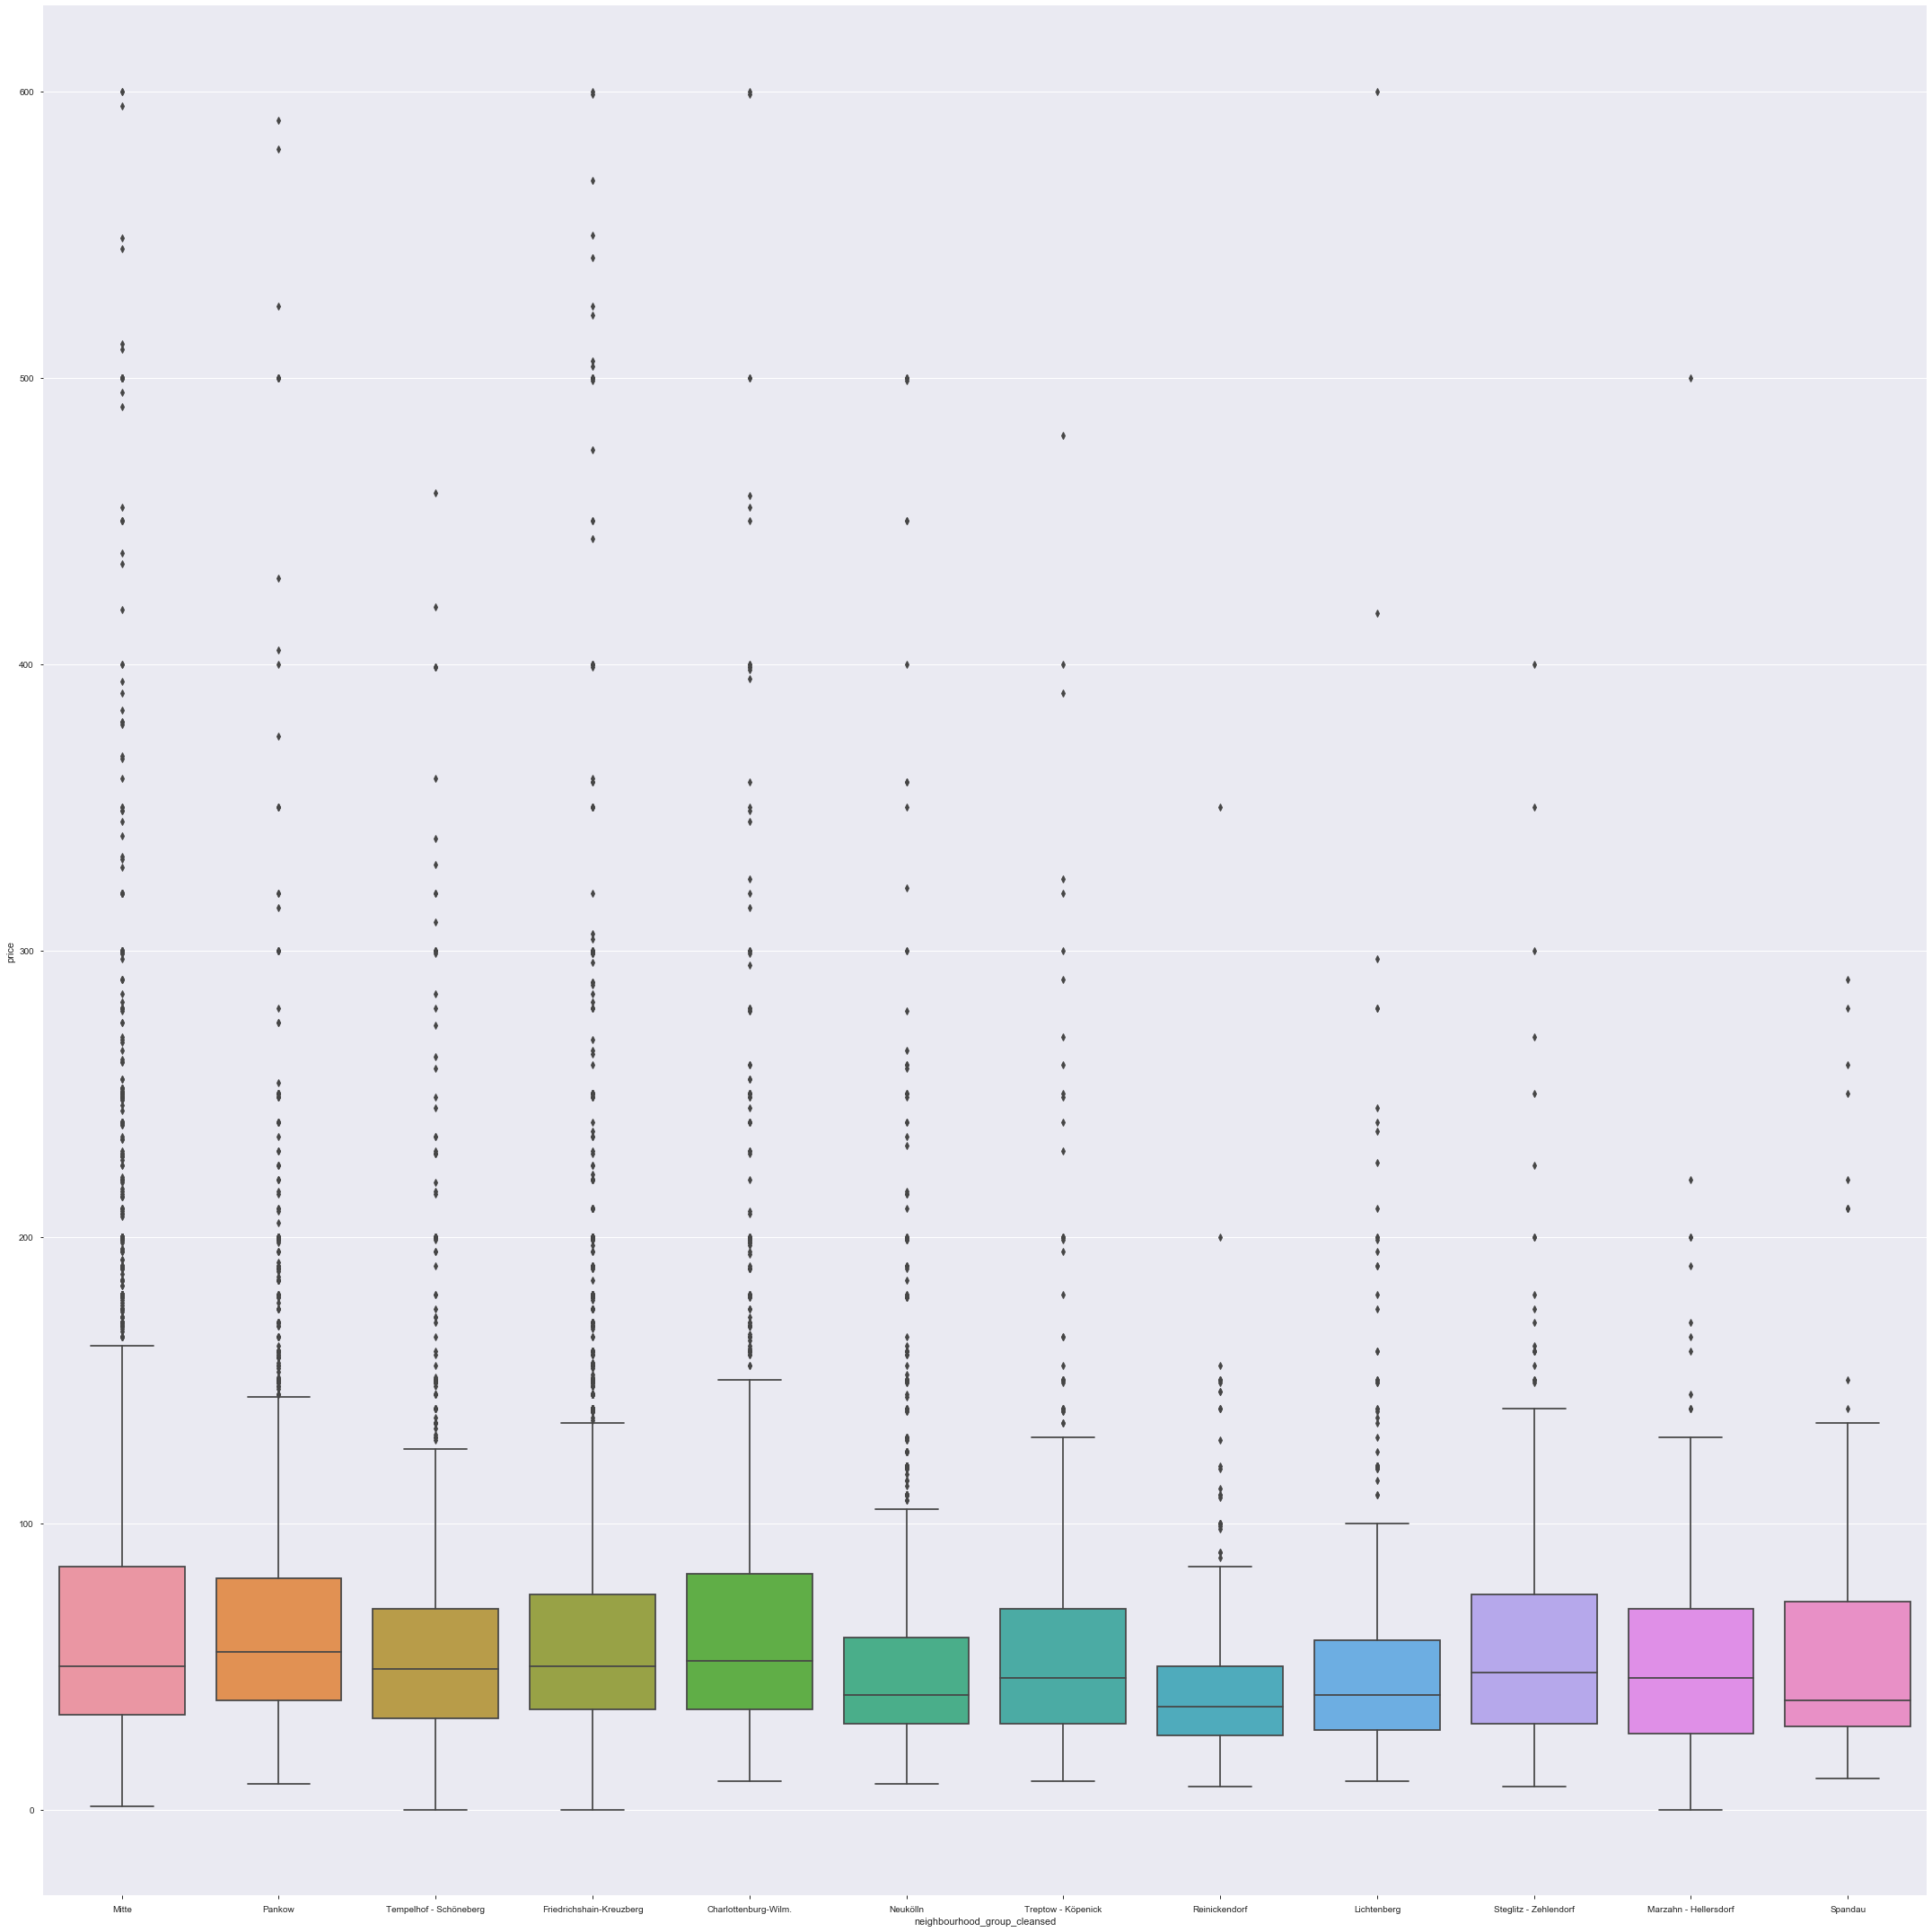

In [34]:
sns.catplot(x='neighbourhood_group_cleansed', y='price', data=before_dummies_df, kind="box", height=30);

# Entscheidungsbäume

## Imports für die Entscheidungsbäume

In [35]:
from sklearn.tree import DecisionTreeRegressor
import pydotplus, graphviz
from sklearn.externals.six import StringIO
from sklearn import tree
from IPython.display import Image

c:\users\luisraphaelramer\analyticsproit\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Gespeichertes DataFrame nutzbar machen

In [36]:
tree_df = before_dummies_df
tree_df

,accommodates,number_of_reviews,review_scores_rating,neighbourhood_group_cleansed,beds,bedrooms,room_type,cancellation_policy,name,price,is_review_scores_rating_real,has_Wifi,has_Heating,has_Kitchen
0,1,18,82.00,Mitte,1.0,1.0,Private room,moderate,cafeheaven Pberg/Mitte/Wed for the summer 2019,21.0,1,1,1,0
1,3,127,93.00,Mitte,2.0,1.0,Entire home/apt,moderate,Berlin-Mitte Value! Quiet courtyard/very central,60.0,1,1,1,1
2,4,145,93.00,Pankow,2.0,1.0,Entire home/apt,strict_14_with_grace_period,Fabulous Flat in great Location,90.0,1,1,1,1
3,1,27,89.00,Tempelhof - Schöneberg,1.0,1.0,Private room,strict_14_with_grace_period,BerlinSpot Schöneberg near KaDeWe,28.0,1,1,1,0
4,2,126,99.00,Friedrichshain-Kreuzberg,1.0,1.0,Entire home/apt,moderate,Stylish East Side Loft in Center with AC & 2 b...,125.0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24416,2,0,94.61,Reinickendorf,1.0,1.0,Entire home/apt,flexible,"Gemütliche, helle Unterkunft",40.0,0,0,1,1
24417,2,0,94.61,Friedrichshain-Kreuzberg,1.0,1.0,Private room,flexible,Spacious Room in trendy Area,54.0,0,1,1,1
24419,1,0,94.61,Pankow,1.0,0.0,Private room,flexible,Gemütliches Privatzimmer in Friedrichshain(zen...,36.0,0,1,1,1
24420,2,0,94.61,Friedrichshain-Kreuzberg,2.0,1.0,Private room,flexible,Schönes Balkonzimmer im Herzen von Friedrichshain,50.0,0,1,1,1


In [37]:
dt = DecisionTreeRegressor(max_depth=3)
dt_cv = cross_validate(dt, X, target_df.price, cv=5, return_estimator=True)
dt_cv

{'fit_time': array([0.02787757, 0.04242349, 0.0432682 , 0.04738784, 0.04605007]),
 'score_time': array([0.00310349, 0.00458217, 0.00500035, 0.00456929, 0.0050025 ]),
 'estimator': (DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                        max_leaf_nodes=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        presort=False, random_state=None, splitter='best'),
  DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                        max_leaf_nodes=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        presort=False, random_state=None, splitter='best'),
  DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                  

In [38]:
dot_data = StringIO()
tree.export_graphviz(dt_cv['estimator'][0], out_file=dot_data, feature_names=X.columns, filled=True, rounded=True, special_characters=True)

In [39]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

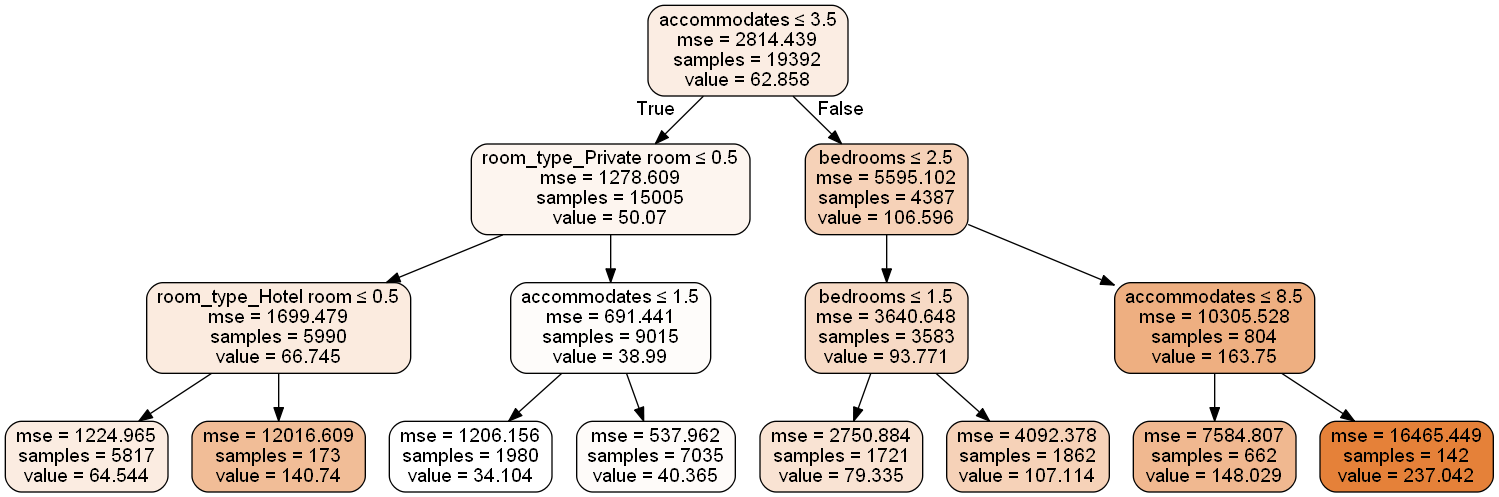

In [40]:
Image(graph.create_png())

## Random Forest Regression

In [41]:
from sklearn.ensemble import RandomForestRegressor

In [42]:
rfr = RandomForestRegressor(n_estimators=10, max_depth=3)
rfr_cv = cross_validate(rfr, X, target_df.price, cv=5, return_estimator=True)
rfr_cv

{'fit_time': array([0.23466587, 0.23007035, 0.23040628, 0.22727728, 0.23353887]),
 'score_time': array([0.00899196, 0.00801444, 0.00704026, 0.00899482, 0.00797081]),
 'estimator': (RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                        max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=10,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                        max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=10

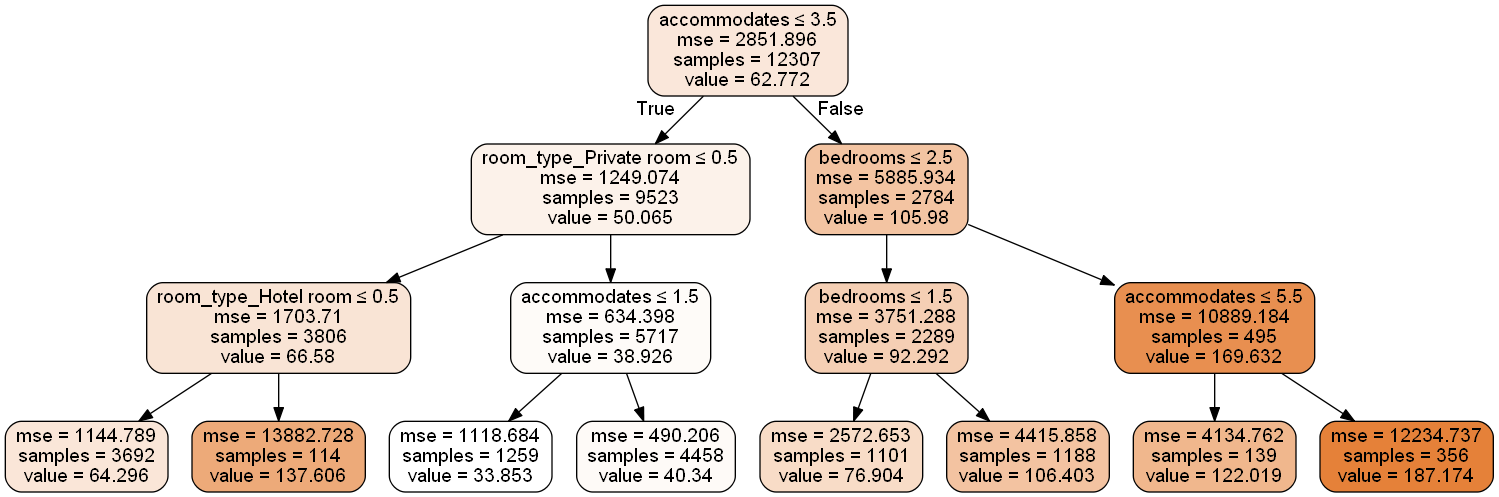

In [43]:
dot_data2 = StringIO()
# first [0] is for access the estimator from index '0' (e.g. RandomForestRegressor), second [0] is for first RandomForest (of n_estimators)
tree.export_graphviz(rfr_cv['estimator'][0][0], out_file=dot_data2, feature_names=X.columns, filled=True, rounded=True, special_characters=True)
graph2 = pydotplus.graph_from_dot_data(dot_data2.getvalue())
Image(graph2.create_png())

In [44]:
from sklearn.datasets import make_regression

In [45]:
#print(rfr_cv['estimator'][0].feature_importances_)

In [46]:
#X.head()